In [1]:
#pip install torchsummary

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from models import resnet

In [2]:
import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher

from jupyterplot import ProgressPlot
import numpy as np
import time
import mlogger
import utils
import argparse


Files already downloaded and verified


In [3]:
# import sys,os,argparse
# # def arg_parser():
    
# parser = argparse.ArgumentParser('MAML with Higher')

# # General
# general_params = parser.add_argument_group('General')
# general_params.add_argument('--data', type=str, default="./data",
#                             help='Path to the folder the data is downloaded to.')
# general_params.add_argument('--dataset', type=str,
#                             choices=["omniglot", "mini-imagenet", "fc100",
#                                      "cifarfs", "tiered-imagenet"], default='omniglot',
#                             help='Name of the dataset (default: omniglot).')

# meta_params = parser.add_argument_group('Meta Learning Parameters')
# meta_params.add_argument('--ways', type=int, default=5,
#                             help='Number of classes per task (N in "N-way", default: 5).')
# meta_params.add_argument('--shots', type=int, default=1,
#                             help='Number of training example per class (k in "k-shot", default: 5).')
# meta_params.add_argument('--adaptation-steps', type=int, default=1,
#                             help='Number of adaptation steps on meta-train datasets.')
# meta_params.add_argument('--num-tasks', type=int, default=32,
#                           help='Number of tasks to sample from task distribution.')
# meta_params.add_argument('--first-order', action='store_true',
#                           help='Use the first order approximation, do not use highers-order '
#                                'derivatives during meta-optimization.')
# meta_params.add_argument('--meta-lr', type=float, default=0.001,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--fast-lr', type=float, default=0.1,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--num-test-task', type=int, default=32,
#                             help='Number of test task used to calculate meta test and meta val')


# # Model
# model_params = parser.add_argument_group('Model')
# model_params.add_argument('--input', type=int, default=32,
#                           help='Input to dimension')
# model_params.add_argument('--fine-tune', type=int, default=0,
#                           help='Only meta learn the FC layer')

# # Optimization
# optim_params = parser.add_argument_group('Optimization')
# optim_params.add_argument('--num-epochs', type=int, default=50000,
#                           help='Number of epochs of meta-training (default: 50000).')
# optim_params.add_argument('--seed', type=int, default=utils.fix_seeds(),
#                           help='Number of epochs of meta-training (default: 101).')




# # Misc
# misc = parser.add_argument_group('Misc')
# misc.add_argument('--num-workers', type=int, default=4,
#                   help='Number of workers to use for data-loading (default: 1).')
# misc.add_argument('--device', type=str, default=utils.get_compute_device(), help="Compute device information")


# # Visualization
# viz = parser.add_argument_group('Misc')
# viz.add_argument('--wand_project', type=str, default="Github_Rapo",
#                   help='Wandb project name should go here')
# viz.add_argument('--username', type=str, default="hikmatkhan",
#                   help='Wandb username should go here')
# viz.add_argument('--wandb_logging', type=bool, default=True,
#                   help='If True, Logs will be reported on wandb.')
# viz.add_argument('--verbose', action='store_true')
# #     args = parser.parse_args()
# #     return parser.parse_args()
# # args = parser.parse_args()


In [4]:
# def main(argv):
#     print(argv)
    
# main(sys.argv)

In [5]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [6]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [7]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [9]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 8
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


X.size: torch.Size([10, 1, 28, 28])


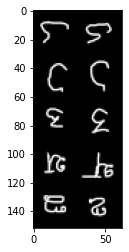

In [11]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [8]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

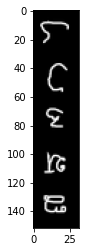

In [13]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

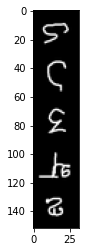

In [14]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([3, 3, 0, 0, 4, 4, 1, 1, 2, 2])


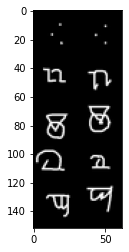

In [15]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([1, 1, 0, 0, 4, 4, 2, 2, 3, 3])


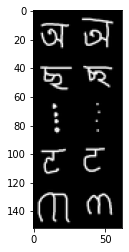

In [16]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [4]:
model = resnet.ResNet18S(out_dim=ways).to(device)
print(model)
# model = resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features

# num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)

# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

NameError: name 'ways' is not defined

In [18]:
# print(model.conv1.weight[0].grad)

In [19]:


# def main(argv):
    

In [9]:

meta_lr_lst = [0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
fast_lr_lst = [0.1, 0.5, 0.9, 0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
adaptation_steps_lst = [1, 5]
shots_lst = [1, 5]
meta_batch_lst = [16]

epochs = 1000
ways = 5
dataset_name = "omniglot"
model = resnet.ResNet18S(out_dim=ways).to(device)

for meta_lr in meta_lr_lst:
    for fast_lr in fast_lr_lst:
        for adaptation_steps in adaptation_steps_lst:
            for shots in shots_lst:
                for meta_batch in meta_batch_lst:

        #             meta_lr = 0.005
        #             fast_lr = 0.01
        #             adaptation_steps = 1
                    optim_meta = optim.Adam(model.parameters(), lr=meta_lr)
                    epochs = 1000
                    # pp = ProgressPlot(plot_names=["ACC", "LOSS"],
                    #                   line_names=["SS", "QS"])
                    tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)



                    WANDB_LOGGER = True
                    if(WANDB_LOGGER):
                        import wandb
                        wandb.init(project="JOmniGlot", entity="hikmatkhan-", reinit=True)
                        wandb.watch(model, log_freq=10)
                        wandb.log({"Dataset":dataset_name,
                                  "Ways":ways,
                                  "Shots":shots,
                                  "Meta Batch": meta_batch,
                                  "Meta_lr": meta_lr,
                                  "Fast_lr": fast_lr,
                                  "Adaptation Step": adaptation_steps})
        #             if __name__ == "__main__":

                #     meta_train_spt_loss = mlogger.metric.Average()
                #     meta_train_spt_acc = mlogger.metric.Average()
                #     meta_train_qry_loss = mlogger.metric.Average()
                #     meta_train_qry_acc = mlogger.metric.Average()

                    for e in range(epochs):
                        optim_meta.zero_grad()
                        model.train()
                        meta_train_loss = mlogger.metric.Average()
                        meta_train_acc = mlogger.metric.Average()
                        meta_val_loss = mlogger.metric.Average()
                        meta_val_acc = mlogger.metric.Average()
                        meta_test_loss = mlogger.metric.Average()
                        meta_test_acc = mlogger.metric.Average()
                        for t in range(meta_batch):
                            X, y = tasksets.train.sample()

                            X, y = X.to(device), y.to(device)
                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_train_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X[meta_test_indices])
                                meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
                                meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
                                meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())

                                meta_train_qry_loss.backward()


                        optim_meta.step()
                        if(WANDB_LOGGER):
                            wandb.log({"Meta Update": e})
                        print("Meta-Update")

                        for t in range(meta_batch):
                            model.eval()
                            X_val, y_val = tasksets.validation.sample()
                            X_val, y_val = X_val.to(device), y_val.to(device)

                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_val[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_val_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_val[meta_test_indices])
                                meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
                                meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
                                meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())



                        for t in range(meta_batch):
                            model.eval()
                            X_test, y_test = tasksets.test.sample()
                            X_test, y_test = X_test.to(device), y_test.to(device)

                            meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_test[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_test_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_test[meta_test_indices])
                                meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
                                meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
                                meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())


                #                 meta_train_qry_loss.backward()

                        if(WANDB_LOGGER):
                            wandb.log({
                                   "Meta Train Acc": meta_train_acc.value,
                                   "Meta Train Loss": meta_train_loss.value,
                                    "Meta Val Acc": meta_val_acc.value,
                                    "Meta Val Loss": meta_val_loss.value,
                                    "Meta Test Acc": meta_test_acc.value,
                                    "Meta Test Loss": meta_test_loss.value
                                   })
                        print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
                             "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
                             "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


                        meta_train_loss.reset()
                        meta_train_acc.reset()
                        meta_val_loss.reset()
                        meta_val_acc.reset()
                        meta_test_loss.reset()
                        meta_test_acc.reset()

                
    

Files already downloaded and verified
Files already downloaded and verified


wandb: Currently logged in as: hikmatkhan- (use `wandb login --relogin` to force relogin)


Meta-Update
Epoch| 0 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 9.44802397489548 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.352135252034979e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.2817969334056387e+18
Meta-Update
Epoch| 1 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 11.733553409576416 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.731072923871478e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.440134593801094e+17
Meta-Update
Epoch| 2 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 10.02449479699135 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.455932599877501e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.568409512662795e+18
Meta-Update
Epoch| 3 | Meta Train Acc: 0.2000000029802322  Meta Train Loss: 9.107681050896643 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.887189703593034e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.793587351007527e+18
Meta-Update
Epoch| 4 | Meta Train Acc

Meta-Update
Epoch| 34 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 10.956022381782534 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.853938527670632e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.1782196567141253e+18
Meta-Update
Epoch| 35 | Meta Train Acc: 0.22500000335276124  Meta Train Loss: 8.883721992373466 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.3688076536530857e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.22063569006415e+18
Meta-Update
Epoch| 36 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 9.273091167211533 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.141650966612804e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.974025919319246e+18
Meta-Update
Epoch| 37 | Meta Train Acc: 0.1875000027939677  Meta Train Loss: 10.478975549340248 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.350201231234827e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.124305933139706e+18
Meta-Update
Epoch| 38 | Meta T

Meta-Update
Epoch| 68 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 9.85036626458168 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.407204450990816e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.419226287790622e+18
Meta-Update
Epoch| 69 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 7.164714537560939 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.47845533288471e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.54713503673693e+18
Meta-Update
Epoch| 70 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 8.386228904128075 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.120727374648836e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3525206264006574e+19
Meta-Update
Epoch| 71 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 10.584040597081183 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4593860166668517e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4305342474384574e+19
Meta-Update
Epoch| 72 | Meta Train

Meta-Update
Epoch| 102 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 7.706640958786012 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.823970738446795e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.243448142568881e+18
Meta-Update
Epoch| 103 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 8.12202912569046 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.90966365105868e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.58595995459833e+18
Meta-Update
Epoch| 104 | Meta Train Acc: 0.2000000029802322  Meta Train Loss: 7.873917005956176 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.742867393527677e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.9961660174903547e+18
Meta-Update
Epoch| 105 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 8.716992497444151 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.637370103246094e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.690113358202928e+18
Meta-Update
Epoch| 106 | Meta Tra

Meta-Update
Epoch| 136 | Meta Train Acc: 0.18750000279396772  Meta Train Loss: 6.0231964737176895 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.697412109826522e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.100332646950765e+18
Meta-Update
Epoch| 137 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 6.026123300194741 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.14609165653246e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.184746843232797e+18
Meta-Update
Epoch| 138 | Meta Train Acc: 0.26250000391155487  Meta Train Loss: 6.819265775382518 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.229288762162019e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.701765779248906e+18
Meta-Update
Epoch| 139 | Meta Train Acc: 0.2375000035390258  Meta Train Loss: 7.069967575371267 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.900589417441001e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.477449017587401e+18
Meta-Update
Epoch| 140 | Meta

Meta-Update
Epoch| 170 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 6.535892874002457 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.963879866040322e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.563468359689829e+16
Meta-Update
Epoch| 171 | Meta Train Acc: 0.23750000353902573  Meta Train Loss: 5.158684119582177 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.298574292130202e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.143031756226558e+16
Meta-Update
Epoch| 172 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 5.772585391998292 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.865111160232346e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0185541571261237e+17
Meta-Update
Epoch| 173 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 5.7971026077866545 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.62964510799954e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.733325940647525e+16
Meta-Update
Epoch| 174 | Me

Meta-Update
Epoch| 204 | Meta Train Acc: 0.2125000040978193  Meta Train Loss: 5.690270565450191 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6993638493493658e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.6011954676393574e+17
Meta-Update
Epoch| 205 | Meta Train Acc: 0.28750000428408384  Meta Train Loss: 4.93184833228588 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6312507897833066e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7345598071124787e+17
Meta-Update
Epoch| 206 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 6.629013866186144 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.747175317914255e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7964907444397674e+17
Meta-Update
Epoch| 207 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 7.048019200563431 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.305641840874619e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4539489084414374e+17
Meta-Update
Epoch| 208 | 

Meta-Update
Epoch| 238 | Meta Train Acc: 0.2375000035390258  Meta Train Loss: 6.4725147634744635 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.495284436467713e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.612953628632679e+16
Meta-Update
Epoch| 239 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 6.066073894500732 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.26695353328599e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.416547458954035e+16
Meta-Update
Epoch| 240 | Meta Train Acc: 0.12500000186264512  Meta Train Loss: 5.942647993564606 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.267588195234611e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.228980868428595e+16
Meta-Update
Epoch| 241 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 5.050412058830261 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.941488528967597e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.403928699257487e+17
Meta-Update
Epoch| 242 | Meta

Meta-Update
Epoch| 272 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.5039588138461095 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.310223449167233e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2923796424637806e+18
Meta-Update
Epoch| 273 | Meta Train Acc: 0.2875000042840838  Meta Train Loss: 4.172778993844986 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1806518793490924e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2233581908721661e+18
Meta-Update
Epoch| 274 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 4.38539694994688 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2401694358980526e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2648065794886858e+18
Meta-Update
Epoch| 275 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 4.681166604161263 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.153052733037609e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0807506479863562e+18
Meta-Update
Epoch| 276 |

Meta-Update
Epoch| 306 | Meta Train Acc: 0.28750000428408384  Meta Train Loss: 3.846049964427948 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3628419482090212e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.336510598933905e+18
Meta-Update
Epoch| 307 | Meta Train Acc: 0.1875000027939677  Meta Train Loss: 4.517917953431608 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.204745232835412e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2072540434920899e+18
Meta-Update
Epoch| 308 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 4.810830660164356 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1408702988206738e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.215530050334491e+18
Meta-Update
Epoch| 309 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 4.977071106433869 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.129380050123096e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1663740078978499e+18
Meta-Update
Epoch| 310 | M

Meta-Update
Epoch| 340 | Meta Train Acc: 0.23750000353902578  Meta Train Loss: 3.8867598697543144 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1159966142011802e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1571173569425572e+18
Meta-Update
Epoch| 341 | Meta Train Acc: 0.2125000031664968  Meta Train Loss: 3.8320214450359344 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1001088215036724e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1345550433331446e+18
Meta-Update
Epoch| 342 | Meta Train Acc: 0.1875000027939677  Meta Train Loss: 4.383448213338853 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0309411133907272e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.113356626653348e+18
Meta-Update
Epoch| 343 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 3.717043727636337 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0724885267732234e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.075325623255171e+18
Meta-Update
Epoch| 344

Meta-Update
Epoch| 374 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 4.9984278827905655 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.649381582071398e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.746970862603468e+16
Meta-Update
Epoch| 375 | Meta Train Acc: 0.2625000039115548  Meta Train Loss: 3.654756441712379 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.258032027218739e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.759437917860659e+16
Meta-Update
Epoch| 376 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 6.068721935153007 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.988435588284416e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.963924371400295e+16
Meta-Update
Epoch| 377 | Meta Train Acc: 0.2125000031664967  Meta Train Loss: 4.55453696846962 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.487537900060671e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.513127637332788e+16
Meta-Update
Epoch| 378 | Meta 

Meta-Update
Epoch| 409 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.115387171506882 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3987184604413951.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4434161985126399.5
Meta-Update
Epoch| 410 | Meta Train Acc: 0.18750000279396772  Meta Train Loss: 4.135458007454873 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3682302391484416.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4188438148415487.5
Meta-Update
Epoch| 411 | Meta Train Acc: 0.1375000020489097  Meta Train Loss: 4.581930324435233 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4442149886099456.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4504439897456640.0
Meta-Update
Epoch| 412 | Meta Train Acc: 0.22500000335276124  Meta Train Loss: 4.276318855583668 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5361832608923647.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5272525089013760.0
Meta-Update
Epoch| 413 | Meta Train Acc: 0.2125000031

Epoch| 443 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 5.284498751163483 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0009591605624834e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.158372568114135e+17
Meta-Update
Epoch| 444 | Meta Train Acc: 0.23750000447034833  Meta Train Loss: 4.349900253117084 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.806062447021262e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1432711248727246e+17
Meta-Update
Epoch| 445 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.7087593600153923 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0096226437850725e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0916808554971136e+17
Meta-Update
Epoch| 446 | Meta Train Acc: 0.2125000031664967  Meta Train Loss: 4.643793612718582 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3404692171404082e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1269236364568166e+17
Meta-Update
Epoch| 447 | Meta Train 

Meta-Update
Epoch| 477 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 4.27417478710413 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.668200694078505e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.6059971122272666e+17
Meta-Update
Epoch| 478 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 3.934127621352673 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.554993548806062e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.4899816811134976e+17
Meta-Update
Epoch| 479 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 4.215330570936203 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6484044811416368e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7242052637320806e+17
Meta-Update
Epoch| 480 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.81955224275589 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6252248540302544e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.970881212819701e+17
Meta-Update
Epoch| 481 | M

Meta-Update
Epoch| 511 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.0546914190053944 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.603682908273377e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.838740197731205e+17
Meta-Update
Epoch| 512 | Meta Train Acc: 0.2125000031664968  Meta Train Loss: 3.707204408943653 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.671560786167726e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6531272643484054e+17
Meta-Update
Epoch| 513 | Meta Train Acc: 0.2500000046566129  Meta Train Loss: 4.510776072740554 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.64330079256576e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4302707851250894e+17
Meta-Update
Epoch| 514 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.945617698132992 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5351571936182272e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5585914263909168e+17
Meta-Update
Epoch| 515 | Me

Meta-Update
Epoch| 545 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 3.568565867841244 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7595044237777312e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5147093106622458e+17
Meta-Update
Epoch| 546 | Meta Train Acc: 0.2125000031664968  Meta Train Loss: 3.46398427337408 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5589071816491005e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.7128127283488355e+17
Meta-Update
Epoch| 547 | Meta Train Acc: 0.2625000039115548  Meta Train Loss: 2.799334928393365 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.629643741457285e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6291456809435142e+17
Meta-Update
Epoch| 548 | Meta Train Acc: 0.16250000242143872  Meta Train Loss: 3.9244250133633614 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6247623500641075e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.70717147134165e+17
Meta-Update
Epoch| 549 | M

Meta-Update
Epoch| 579 | Meta Train Acc: 0.22500000335276132  Meta Train Loss: 3.3017055466771126 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.3919891411461734e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.1316030551543e+17
Meta-Update
Epoch| 580 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 3.5005834773182865 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.011200132411556e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.9554996249677e+17
Meta-Update
Epoch| 581 | Meta Train Acc: 0.1875000027939677  Meta Train Loss: 3.382310181856155 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.224500942908947e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.1242036210722406e+17
Meta-Update
Epoch| 582 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.991949938237667 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.298305177739591e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.1961879386731315e+17
Meta-Update
Epoch| 583 | Meta

Meta-Update
Epoch| 613 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 3.340575352311135 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.601897202522522e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.200587269544347e+17
Meta-Update
Epoch| 614 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 2.84508565813303 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.423247543924164e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.535996319549358e+17
Meta-Update
Epoch| 615 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 3.423954918980599 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.112757078126756e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.176513677202555e+17
Meta-Update
Epoch| 616 | Meta Train Acc: 0.17500000260770318  Meta Train Loss: 3.4636939764022827 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.00090683113472e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.860913725036298e+17
Meta-Update
Epoch| 617 | Meta

Meta-Update
Epoch| 647 | Meta Train Acc: 0.23750000353902578  Meta Train Loss: 3.3965301886200905 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.908777490609603e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.733473203512934e+17
Meta-Update
Epoch| 648 | Meta Train Acc: 0.27500000502914196  Meta Train Loss: 3.70450596511364 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.207816601446647e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.876468534700933e+17
Meta-Update
Epoch| 649 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.719248175621033 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.343050282485678e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.994152786094982e+17
Meta-Update
Epoch| 650 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.0469028726220126 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.963917198392031e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.308129986461042e+17
Meta-Update
Epoch| 651 | Me

Meta-Update
Epoch| 681 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 2.938177898526192 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9854942449762304.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0750459102887936e+16
Meta-Update
Epoch| 682 | Meta Train Acc: 0.2125000031664968  Meta Train Loss: 3.0468795374035835 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7241043472809985.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7788008531034111.0
Meta-Update
Epoch| 683 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 4.463939316570758 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6141941527871488.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6385186279260159.0
Meta-Update
Epoch| 684 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 3.8331413343548775 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6516223785304065.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6656715420336127.0
Meta-Update
Epoch| 685 | Meta Train Acc: 0.1875

Meta-Update
Epoch| 716 | Meta Train Acc: 0.18750000279396772  Meta Train Loss: 3.7086642012000084 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4805550776778753.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4719705570934784.0
Meta-Update
Epoch| 717 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 3.3623174354434013 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4360269757153279.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5043259801862144.0
Meta-Update
Epoch| 718 | Meta Train Acc: 0.2375000044703483  Meta Train Loss: 3.6789929047226906 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5001414321373185.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5503480361910272.0
Meta-Update
Epoch| 719 | Meta Train Acc: 0.25000000372529035  Meta Train Loss: 3.0133849605917926 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5043547229126656.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5066320236249088.0
Meta-Update
Epoch| 720 | Meta Train Acc: 0.2125000

Meta-Update
Epoch| 751 | Meta Train Acc: 0.21250000316649673  Meta Train Loss: 3.5865920484066005 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2523390887854080.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2884361884008448.0
Meta-Update
Epoch| 752 | Meta Train Acc: 0.2375000035390258  Meta Train Loss: 2.781837582588196 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2810204768960512.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2661941415772159.5
Meta-Update
Epoch| 753 | Meta Train Acc: 0.17500000260770318  Meta Train Loss: 2.8490355685353284 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2603162414350336.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2483930221510656.5
Meta-Update
Epoch| 754 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.8028904423117638 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2649131172495360.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2256453301698560.0
Meta-Update
Epoch| 755 | Meta Train Acc: 0.2625000

Meta-Update
Epoch| 786 | Meta Train Acc: 0.21250000316649675  Meta Train Loss: 2.2819893360137944 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3734445181894655.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3990219015585792.0
Meta-Update
Epoch| 787 | Meta Train Acc: 0.2000000029802322  Meta Train Loss: 2.5247398689389233 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3497342426677248.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4038949982961664.5
Meta-Update
Epoch| 788 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 2.7491407692432404 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3251983729295359.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3750965010235392.5
Meta-Update
Epoch| 789 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 3.1696240454912186 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3933830423511040.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3625825400258559.0
Meta-Update
Epoch| 790 | Meta Train Acc: 0.237500

Meta-Update
Epoch| 821 | Meta Train Acc: 0.21250000409781933  Meta Train Loss: 2.672291412949562 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3830326342189056.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4005866638409728.0
Meta-Update
Epoch| 822 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 2.5791521146893497 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4324888252776448.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4945887876874241.0
Meta-Update
Epoch| 823 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.9193232879042625 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4024127295848448.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4097574340395009.0
Meta-Update
Epoch| 824 | Meta Train Acc: 0.23750000447034836  Meta Train Loss: 3.2571945711970325 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3928032418988032.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3988057539739648.0
Meta-Update
Epoch| 825 | Meta Train Acc: 0.212500

Meta-Update
Epoch| 856 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.823972098529339 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2479549799464959.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2813297145413632.5
Meta-Update
Epoch| 857 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 2.551800444722175 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2614458589380608.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3088872414117888.5
Meta-Update
Epoch| 858 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 2.4593231603503227 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2714537627222015.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2598491847131136.0
Meta-Update
Epoch| 859 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 2.0881514847278595 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2781571673227263.5 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2773252304797695.5
Meta-Update
Epoch| 860 | Meta Train Acc: 0.250000003

Meta-Update
Epoch| 891 | Meta Train Acc: 0.2125000031664967  Meta Train Loss: 3.000997565686702 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5915930215317505.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5644581127323648.0
Meta-Update
Epoch| 892 | Meta Train Acc: 0.23750000353902576  Meta Train Loss: 2.5437982976436615 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6691391224676352.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6751579285749760.0
Meta-Update
Epoch| 893 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 2.5254827663302426 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5753821271687167.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7261714546425857.0
Meta-Update
Epoch| 894 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.429783664643765 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5309788208496640.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5399301651955711.0
Meta-Update
Epoch| 895 | Meta Train Acc: 0.1750000026

Meta-Update
Epoch| 926 | Meta Train Acc: 0.2375000035390258  Meta Train Loss: 3.63877634704113 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.161227831915315e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.468479155516211e+16
Meta-Update
Epoch| 927 | Meta Train Acc: 0.1500000022351742  Meta Train Loss: 4.152108907699585 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.3983357696147452e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.422033298646631e+16
Meta-Update
Epoch| 928 | Meta Train Acc: 0.23750000447034833  Meta Train Loss: 4.116382829844951 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.9212755185696764e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.587416443899085e+16
Meta-Update
Epoch| 929 | Meta Train Acc: 0.18750000279396772  Meta Train Loss: 3.541150912642479 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.1270074790707204e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7825359353282564e+16
Meta-Update
Epoch| 930 | Me

Meta-Update
Epoch| 960 | Meta Train Acc: 0.17500000260770318  Meta Train Loss: 3.699538938701153 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.409588487293501e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3742336126432051e+17
Meta-Update
Epoch| 961 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 3.671829879283905 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5209843041868186e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1522663305655091e+17
Meta-Update
Epoch| 962 | Meta Train Acc: 0.25000000372529024  Meta Train Loss: 4.3103197067976 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.790748066735718e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.890070608163636e+17
Meta-Update
Epoch| 963 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 3.5826109573245044 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.823734459111833e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4155910942503731e+17
Meta-Update
Epoch| 964 | Me

Meta-Update
Epoch| 994 | Meta Train Acc: 0.2625000039115548  Meta Train Loss: 3.315435186028481 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.048679430813124e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.577880282274202e+17
Meta-Update
Epoch| 995 | Meta Train Acc: 0.2875000042840838  Meta Train Loss: 3.479455567896366 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4916830552223913e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.9247710740718554e+18
Meta-Update
Epoch| 996 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.258501060307026 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6153056628860526e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.6868894199017636e+18
Meta-Update
Epoch| 997 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 4.301327079534531 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.549293305997558e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8523403773322196e+18
Meta-Update
Epoch| 998 | M

Dataset,omniglot
Ways,5
Shots,1
Meta Batch,16
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,15732
_timestamp,1629352655
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▅▆▃▃▃▅▆▃▃▅▅▂▆▅▄▄▃▃▃▄▆▄▆▆▅▃▅▂▆▄▆▃█▂▆▃▄▁▅▆


Meta-Update
Epoch| 0 | Meta Train Acc: 0.23999999510124329  Meta Train Loss: 3.089100241661072 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.950696047644508e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5964563225565463e+19
Meta-Update
Epoch| 1 | Meta Train Acc: 0.19499999517574912  Meta Train Loss: 2.817854769527912 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.241678273932166e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0140711424180093e+19
Meta-Update
Epoch| 2 | Meta Train Acc: 0.20749999303370717  Meta Train Loss: 2.580876819789409 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.937052915038421e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.489565122972877e+18
Meta-Update
Epoch| 3 | Meta Train Acc: 0.23249999200925228  Meta Train Loss: 2.4057406932115555 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.014820451613409e+17 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.471749105120706e+17
Meta-Update
Epoch| 4 | Meta Train

Meta-Update
Epoch| 34 | Meta Train Acc: 0.22999999346211555  Meta Train Loss: 3.0461473688483234 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4311415680186907e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4905833902685775e+22
Meta-Update
Epoch| 35 | Meta Train Acc: 0.18999999621883035  Meta Train Loss: 2.54496294260025 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.798816031173576e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.666304086062664e+21
Meta-Update
Epoch| 36 | Meta Train Acc: 0.1799999941140413  Meta Train Loss: 2.9419016391038895 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.91647167178845e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.899951096164744e+21
Meta-Update
Epoch| 37 | Meta Train Acc: 0.18749999115243557  Meta Train Loss: 2.6442122086882596 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.312425085089112e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.21812523283839e+21
Meta-Update
Epoch| 38 | Meta Tr

Meta-Update
Epoch| 68 | Meta Train Acc: 0.23999999510124326  Meta Train Loss: 1.9820858165621758 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.165724649388796e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.333673571239841e+24
Meta-Update
Epoch| 69 | Meta Train Acc: 0.21249999292194843  Meta Train Loss: 2.4853149503469467 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.603210901454221e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.296668393821663e+24
Meta-Update
Epoch| 70 | Meta Train Acc: 0.1924999938346445  Meta Train Loss: 2.232369028031826 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.969938523715042e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.7788716161703895e+24
Meta-Update
Epoch| 71 | Meta Train Acc: 0.18749999534338713  Meta Train Loss: 2.332013562321663 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.547894092792384e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.727591266760975e+24
Meta-Update
Epoch| 72 | Meta T

Meta-Update
Epoch| 102 | Meta Train Acc: 0.22749999165534973  Meta Train Loss: 1.9939467981457712 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2191951286831317e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.201596596166121e+25
Meta-Update
Epoch| 103 | Meta Train Acc: 0.19999999273568395  Meta Train Loss: 1.8662234619259834 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.3640521496896076e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.3975284433492067e+25
Meta-Update
Epoch| 104 | Meta Train Acc: 0.19749999279156322  Meta Train Loss: 1.8638298809528349 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6587110360070225e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.7686109077388263e+25
Meta-Update
Epoch| 105 | Meta Train Acc: 0.23749999282881618  Meta Train Loss: 1.9064174741506579 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.660269411181761e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.854903184042811e+25
Meta-Update
Epoch| 

Meta-Update
Epoch| 136 | Meta Train Acc: 0.23499999055638907  Meta Train Loss: 1.733826123178005 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.897690407483744e+25 Meta Test Acc: 0.20999998878687615  Meta Test Loss: 1.6975602946861234e+26
Meta-Update
Epoch| 137 | Meta Train Acc: 0.23749999143183226  Meta Train Loss: 1.8523328006267545 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.8264294881513785e+26 Meta Test Acc: 0.20249998848885298  Meta Test Loss: 1.0723123376061754e+26
Meta-Update
Epoch| 138 | Meta Train Acc: 0.25499999150633806  Meta Train Loss: 1.7148401588201525 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.2094319533481825e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.061621507397244e+26
Meta-Update
Epoch| 139 | Meta Train Acc: 0.23999999323859803  Meta Train Loss: 1.7774188145995142 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.07399494178384e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.3445058353057964e+26
Meta-Update
Epoch| 14

Meta-Update
Epoch| 170 | Meta Train Acc: 0.23749999003484845  Meta Train Loss: 2.233528859913349 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.246781830044777e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4361919375058424e+26
Meta-Update
Epoch| 171 | Meta Train Acc: 0.24249999318271873  Meta Train Loss: 2.0474161878228188 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4661452820703076e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4803995193262345e+26
Meta-Update
Epoch| 172 | Meta Train Acc: 0.2549999882467091  Meta Train Loss: 2.368257068097592 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2210753064301765e+26 Meta Test Acc: 0.20249998848885298  Meta Test Loss: 1.206043654203693e+26
Meta-Update
Epoch| 173 | Meta Train Acc: 0.25749998912215233  Meta Train Loss: 2.162766166031361 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0166167313824827e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0852511342996143e+26
Meta-Update
Epoch| 174

Meta-Update
Epoch| 204 | Meta Train Acc: 0.24749999353662136  Meta Train Loss: 1.6709884926676752 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7078520127432745e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5913819050875108e+26
Meta-Update
Epoch| 205 | Meta Train Acc: 0.22499999310821298  Meta Train Loss: 2.032795086503029 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3398284004263249e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.401066246959867e+26
Meta-Update
Epoch| 206 | Meta Train Acc: 0.26249998901039356  Meta Train Loss: 1.9859016090631485 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2967451188341878e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2127782462938938e+26
Meta-Update
Epoch| 207 | Meta Train Acc: 0.23249999200925234  Meta Train Loss: 2.5171329304575925 Meta Val Acc: 0.194999988656491  Meta Val Loss: 1.005796410299648e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1588544011996049e+26
Meta-Update
Epoch| 20

Meta-Update
Epoch| 238 | Meta Train Acc: 0.28749998938292265  Meta Train Loss: 1.5488784760236738 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.636029043996142e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6196725869625373e+26
Meta-Update
Epoch| 239 | Meta Train Acc: 0.28499998990446335  Meta Train Loss: 1.658342577517033 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6758697338565728e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.580012536843449e+26
Meta-Update
Epoch| 240 | Meta Train Acc: 0.23499999102205038  Meta Train Loss: 1.6448153108358379 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5925596489921118e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.760739756104411e+26
Meta-Update
Epoch| 241 | Meta Train Acc: 0.25999998906627303  Meta Train Loss: 1.5589378625154497 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.669629206101044e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7256232543428277e+26
Meta-Update
Epoch| 24

Meta-Update
Epoch| 272 | Meta Train Acc: 0.29499998921528464  Meta Train Loss: 1.5325324907898903 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.84220917296373e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.839578730669501e+26
Meta-Update
Epoch| 273 | Meta Train Acc: 0.33749999152496446  Meta Train Loss: 1.4972234368324284 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1451467461720984e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0698638888126776e+26
Meta-Update
Epoch| 274 | Meta Train Acc: 0.25249999202787876  Meta Train Loss: 1.6040840968489647 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1749690669721725e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.228188407851856e+26
Meta-Update
Epoch| 275 | Meta Train Acc: 0.27499999059364205  Meta Train Loss: 1.5886588990688326 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6252953989889327e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6005513976570602e+26
Meta-Update
Epoch| 2

Meta-Update
Epoch| 306 | Meta Train Acc: 0.24749998981133103  Meta Train Loss: 1.806413821876049 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6754586885171425e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7189597888625493e+26
Meta-Update
Epoch| 307 | Meta Train Acc: 0.24499999498948458  Meta Train Loss: 1.6503518521785736 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.893400767030326e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7178703760390238e+26
Meta-Update
Epoch| 308 | Meta Train Acc: 0.23499999195337293  Meta Train Loss: 1.7906857952475548 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.8421043147528856e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7545663687327037e+26
Meta-Update
Epoch| 309 | Meta Train Acc: 0.1974999918602407  Meta Train Loss: 1.7799461111426353 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.000319162133938e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.954874570479001e+26
Meta-Update
Epoch| 31

Meta-Update
Epoch| 340 | Meta Train Acc: 0.24749999213963744  Meta Train Loss: 1.5478817075490952 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.731282852649041e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.636533665083312e+26
Meta-Update
Epoch| 341 | Meta Train Acc: 0.20499999495223162  Meta Train Loss: 1.5460686907172203 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.716279942755668e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.773745804825625e+26
Meta-Update
Epoch| 342 | Meta Train Acc: 0.22999999206513166  Meta Train Loss: 1.5792458131909368 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.749735234508908e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.742750178868742e+26
Meta-Update
Epoch| 343 | Meta Train Acc: 0.2774999914690852  Meta Train Loss: 1.5251134037971494 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.034892832737326e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.9749515444340425e+26
Meta-Update
Epoch| 344 |

Meta-Update
Epoch| 374 | Meta Train Acc: 0.2449999917298555  Meta Train Loss: 1.5764088556170468 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.533652564806774e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.673034917872497e+26
Meta-Update
Epoch| 375 | Meta Train Acc: 0.24249999225139615  Meta Train Loss: 1.649149350821972 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.084632137768277e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.295253556720523e+26
Meta-Update
Epoch| 376 | Meta Train Acc: 0.22249999316409233  Meta Train Loss: 1.6025964543223379 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.416247319073229e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.954006064440245e+26
Meta-Update
Epoch| 377 | Meta Train Acc: 0.29749999055638904  Meta Train Loss: 1.616158835589886 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.09537994401674e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.885161293700774e+26
Meta-Update
Epoch| 378 | Met

Meta-Update
Epoch| 408 | Meta Train Acc: 0.2924999911338091  Meta Train Loss: 1.5887529626488688 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6944473771925204e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6388688960483077e+27
Meta-Update
Epoch| 409 | Meta Train Acc: 0.3399999886751175  Meta Train Loss: 1.5466411709785461 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.5537351706764067e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.790996943921413e+27
Meta-Update
Epoch| 410 | Meta Train Acc: 0.21499999472871423  Meta Train Loss: 1.7010664716362953 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6174653971539996e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.76686792014347e+27
Meta-Update
Epoch| 411 | Meta Train Acc: 0.2674999888986349  Meta Train Loss: 1.6047754287719727 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4591011784157314e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.7699322932689947e+27
Meta-Update
Epoch| 412

Meta-Update
Epoch| 442 | Meta Train Acc: 0.23749999329447746  Meta Train Loss: 1.5766207873821256 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.635904269106416e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.3300854205425114e+27
Meta-Update
Epoch| 443 | Meta Train Acc: 0.29999999236315494  Meta Train Loss: 1.5180047079920764 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.50341263272582e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.668226635625625e+27
Meta-Update
Epoch| 444 | Meta Train Acc: 0.26999999303370714  Meta Train Loss: 1.581022523343563 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.606785954458857e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.604976568672898e+27
Meta-Update
Epoch| 445 | Meta Train Acc: 0.26499999314546585  Meta Train Loss: 1.5558609068393705 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.5271900431149746e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.477701173454259e+27
Meta-Update
Epoch| 446 |

Meta-Update
Epoch| 476 | Meta Train Acc: 0.2799999946728349  Meta Train Loss: 1.5475242659449575 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.442045203579768e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.5891425845363013e+27
Meta-Update
Epoch| 477 | Meta Train Acc: 0.3449999871663749  Meta Train Loss: 1.5020676031708722 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.355486697812474e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.658783120144994e+27
Meta-Update
Epoch| 478 | Meta Train Acc: 0.2924999902024865  Meta Train Loss: 1.5254542902112012 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.6679227255170107e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.9221223268406136e+27
Meta-Update
Epoch| 479 | Meta Train Acc: 0.2799999914132058  Meta Train Loss: 1.521304436028004 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.750476738293808e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.561538950491378e+27
Meta-Update
Epoch| 480 | M

Meta-Update
Epoch| 510 | Meta Train Acc: 0.3249999890103937  Meta Train Loss: 1.5321894809603689 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.577203545108046e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.67945489897303e+27
Meta-Update
Epoch| 511 | Meta Train Acc: 0.31999999005347496  Meta Train Loss: 1.4798415973782542 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.36447928956512e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.713250274900013e+27
Meta-Update
Epoch| 512 | Meta Train Acc: 0.31249998789280664  Meta Train Loss: 1.5008748546242714 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.637480993040269e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.004048843655156e+27
Meta-Update
Epoch| 513 | Meta Train Acc: 0.3149999910965562  Meta Train Loss: 1.5201431363821032 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.820726927278293e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.770713598236818e+27
Meta-Update
Epoch| 514 | Met

Meta-Update
Epoch| 544 | Meta Train Acc: 0.3149999892339109  Meta Train Loss: 1.474431611597538 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.21564517303169e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.277010517695665e+27
Meta-Update
Epoch| 545 | Meta Train Acc: 0.2849999889731408  Meta Train Loss: 1.4620703607797623 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.141801362318363e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.36503251435079e+27
Meta-Update
Epoch| 546 | Meta Train Acc: 0.28999999025836587  Meta Train Loss: 1.4892209246754644 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.053348209914002e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.483537718694235e+27
Meta-Update
Epoch| 547 | Meta Train Acc: 0.2599999923259021  Meta Train Loss: 1.5092724710702896 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.128682277740815e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.904761335091393e+27
Meta-Update
Epoch| 548 | Meta 

Meta-Update
Epoch| 578 | Meta Train Acc: 0.3024999895133079  Meta Train Loss: 1.5303638204932215 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.234264689310396e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.098875217009775e+27
Meta-Update
Epoch| 579 | Meta Train Acc: 0.28749999124556785  Meta Train Loss: 1.5427088290452955 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.345486491904242e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.315297472890412e+27
Meta-Update
Epoch| 580 | Meta Train Acc: 0.3024999876506626  Meta Train Loss: 1.4720717146992683 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.257486446874562e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.4083048865989e+27
Meta-Update
Epoch| 581 | Meta Train Acc: 0.32499999087303877  Meta Train Loss: 1.488881327211857 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.28465139889867e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.171717978262456e+27
Meta-Update
Epoch| 582 | Meta 

Meta-Update
Epoch| 612 | Meta Train Acc: 0.3074999903328717  Meta Train Loss: 1.5746940597891808 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.773478008856958e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.870624669021401e+27
Meta-Update
Epoch| 613 | Meta Train Acc: 0.3774999836459757  Meta Train Loss: 1.4245862141251564 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.004760371467567e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.140139587378483e+27
Meta-Update
Epoch| 614 | Meta Train Acc: 0.3149999869056046  Meta Train Loss: 1.5003699138760567 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.934819043250005e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.618686454053796e+27
Meta-Update
Epoch| 615 | Meta Train Acc: 0.38999998569488536  Meta Train Loss: 1.4068486019968989 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.690422964064376e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.934900762326253e+27
Meta-Update
Epoch| 616 | Me

Meta-Update
Epoch| 646 | Meta Train Acc: 0.3424999862909318  Meta Train Loss: 1.5138785466551778 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.18554877053491e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.963391200560827e+27
Meta-Update
Epoch| 647 | Meta Train Acc: 0.3099999902769924  Meta Train Loss: 1.4554871693253517 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.879371409499934e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.81836478022122e+27
Meta-Update
Epoch| 648 | Meta Train Acc: 0.31499998597428197  Meta Train Loss: 1.486415095627308 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.991107876253434e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.922144059451083e+27
Meta-Update
Epoch| 649 | Meta Train Acc: 0.2774999891407788  Meta Train Loss: 1.5634111687541008 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.962094689600352e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.290563391321904e+27
Meta-Update
Epoch| 650 | Meta 

Meta-Update
Epoch| 680 | Meta Train Acc: 0.3374999891966581  Meta Train Loss: 1.3999335244297983 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4366932363076647e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5806488010177017e+28
Meta-Update
Epoch| 681 | Meta Train Acc: 0.37499998882412916  Meta Train Loss: 1.4790373444557194 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5720112680578374e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5060278179085006e+28
Meta-Update
Epoch| 682 | Meta Train Acc: 0.35999999055638926  Meta Train Loss: 1.3864348605275154 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5873223829230149e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5271097236453253e+28
Meta-Update
Epoch| 683 | Meta Train Acc: 0.35499998973682534  Meta Train Loss: 1.3959784284234047 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4423071634464072e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5349891101811552e+28
Meta-Update
Epoch

Meta-Update
Epoch| 714 | Meta Train Acc: 0.35249998513609165  Meta Train Loss: 1.4097507596015935 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2751894315342601e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2475407579190069e+28
Meta-Update
Epoch| 715 | Meta Train Acc: 0.36249998817220325  Meta Train Loss: 1.3917355760931973 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2571554776313852e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3202415161358087e+28
Meta-Update
Epoch| 716 | Meta Train Acc: 0.34749998804181814  Meta Train Loss: 1.4176712036132815 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.225367911737663e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2563574825508031e+28
Meta-Update
Epoch| 717 | Meta Train Acc: 0.3349999915808439  Meta Train Loss: 1.504329837858677 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2852186163818356e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2340911482704937e+28
Meta-Update
Epoch| 

Meta-Update
Epoch| 748 | Meta Train Acc: 0.3024999923072754  Meta Train Loss: 1.4562541842460632 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.351436886204533e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.355615295098157e+28
Meta-Update
Epoch| 749 | Meta Train Acc: 0.37249998934566964  Meta Train Loss: 1.3742589056491852 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2841644513663015e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2886731602806118e+28
Meta-Update
Epoch| 750 | Meta Train Acc: 0.35249998886138206  Meta Train Loss: 1.367796294391155 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.29366481233347e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2658638792926318e+28
Meta-Update
Epoch| 751 | Meta Train Acc: 0.3349999897181989  Meta Train Loss: 1.456746160984039 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3274896108172507e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3196275937356402e+28
Meta-Update
Epoch| 752 |

Meta-Update
Epoch| 782 | Meta Train Acc: 0.36999998893588787  Meta Train Loss: 1.4474079757928848 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3254505003486454e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3735237115289123e+28
Meta-Update
Epoch| 783 | Meta Train Acc: 0.34999998752027744  Meta Train Loss: 1.494136959314346 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.309042446157776e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2823482181489434e+28
Meta-Update
Epoch| 784 | Meta Train Acc: 0.342499986756593  Meta Train Loss: 1.4111729040741923 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3682638807107113e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2613741705247174e+28
Meta-Update
Epoch| 785 | Meta Train Acc: 0.3424999862909317  Meta Train Loss: 1.4630073979496956 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2715829454938973e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3823898291626403e+28
Meta-Update
Epoch| 78

Meta-Update
Epoch| 816 | Meta Train Acc: 0.36499998718500143  Meta Train Loss: 1.4425771981477737 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3445169369640696e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4150214036953623e+28
Meta-Update
Epoch| 817 | Meta Train Acc: 0.3449999876320362  Meta Train Loss: 1.4594340771436691 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3710033771583071e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.400287767842762e+28
Meta-Update
Epoch| 818 | Meta Train Acc: 0.344999990426004  Meta Train Loss: 1.463234029710293 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3911714311937203e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3525739435092366e+28
Meta-Update
Epoch| 819 | Meta Train Acc: 0.3874999862164259  Meta Train Loss: 1.3709989637136462 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3300023377505999e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.390766517782605e+28
Meta-Update
Epoch| 820 

Meta-Update
Epoch| 850 | Meta Train Acc: 0.34749998524785036  Meta Train Loss: 1.3838950991630554 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0263025847376051e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0747486267516948e+28
Meta-Update
Epoch| 851 | Meta Train Acc: 0.33999998494982725  Meta Train Loss: 1.3653326258063319 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0059925719384983e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.917712575090568e+27
Meta-Update
Epoch| 852 | Meta Train Acc: 0.3499999884516  Meta Train Loss: 1.4080608859658241 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0596451631952067e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0479577710080552e+28
Meta-Update
Epoch| 853 | Meta Train Acc: 0.3574999934062362  Meta Train Loss: 1.481090672314167 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0359253767451903e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0596662293769387e+28
Meta-Update
Epoch| 854 

Meta-Update
Epoch| 884 | Meta Train Acc: 0.38999998755753046  Meta Train Loss: 1.3800154030323029 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0455085340784587e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.913574453886e+27
Meta-Update
Epoch| 885 | Meta Train Acc: 0.35999998450279236  Meta Train Loss: 1.3971177488565447 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0194962047217058e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.081363503738667e+28
Meta-Update
Epoch| 886 | Meta Train Acc: 0.35249998560175305  Meta Train Loss: 1.3822200670838354 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.022442850726552e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0539947410179887e+28
Meta-Update
Epoch| 887 | Meta Train Acc: 0.3549999888055026  Meta Train Loss: 1.3872961178421976 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.040739408788711e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0629780877103054e+28
Meta-Update
Epoch| 888 |

Meta-Update
Epoch| 918 | Meta Train Acc: 0.3799999859184026  Meta Train Loss: 1.3280376493930817 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1969362328660622e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1518795365784947e+28
Meta-Update
Epoch| 919 | Meta Train Acc: 0.34249998582527047  Meta Train Loss: 1.4318422526121137 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1608013633793253e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1295266723110845e+28
Meta-Update
Epoch| 920 | Meta Train Acc: 0.3974999859929085  Meta Train Loss: 1.3101478889584535 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1173199784528161e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1713130117501022e+28
Meta-Update
Epoch| 921 | Meta Train Acc: 0.34249998675659304  Meta Train Loss: 1.417706683278084 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1333345340778019e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1348442967784684e+28
Meta-Update
Epoch| 

Meta-Update
Epoch| 952 | Meta Train Acc: 0.36999998474493634  Meta Train Loss: 1.4146642908453946 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.918171453950193e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.247159542197883e+27
Meta-Update
Epoch| 953 | Meta Train Acc: 0.3849999867379666  Meta Train Loss: 1.3520917966961858 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.9302312711428e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.177159276633009e+27
Meta-Update
Epoch| 954 | Meta Train Acc: 0.3724999874830245  Meta Train Loss: 1.3262174427509308 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.183215084457992e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.25104416824539e+27
Meta-Update
Epoch| 955 | Meta Train Acc: 0.35749998874962324  Meta Train Loss: 1.3618559390306473 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.83570912149144e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.825502537995458e+27
Meta-Update
Epoch| 956 | Meta 

Meta-Update
Epoch| 986 | Meta Train Acc: 0.3674999848008157  Meta Train Loss: 1.3815932571887972 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.812947697840689e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.91550491716916e+27
Meta-Update
Epoch| 987 | Meta Train Acc: 0.3374999845400453  Meta Train Loss: 1.3310091346502302 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.5283827635234e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.823926498937085e+27
Meta-Update
Epoch| 988 | Meta Train Acc: 0.327499988488853  Meta Train Loss: 1.41609488427639 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.791447021498598e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.818035826365054e+27
Meta-Update
Epoch| 989 | Meta Train Acc: 0.3549999864771962  Meta Train Loss: 1.3977094143629074 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.91408437030153e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.025529046457274e+27
Meta-Update
Epoch| 990 | Meta Train

Dataset,omniglot
Ways,5
Shots,5
Meta Batch,16
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,20488
_timestamp,1629373152
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▃▂▁▄▃▅▄▃▄▅▅▄▄▅▄▄▄▄▅▆▆▅▆▇█▇▅▆▆▇▆▆▆▆▇▇▇▆▇█


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.89 GiB total capacity; 1.75 GiB already allocated; 23.50 MiB free; 1.78 GiB reserved in total by PyTorch)

In [ ]:
# from jupyterplot import ProgressPlot
# import numpy as np
# import time
# pp = ProgressPlot(line_names=["cos", "no-cos"])
# for i in range(1000):
#     pp.update([[np.sin(i / 100), np.sin(i / 100) * 0.1]])
#     time.sleep(0.01)
# pp.finalize()